In [1]:
# Импорт библиотек

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Загрузка датасета

df = pd.read_csv('customer_retention_data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
# Переименование столбцов

df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [4]:
# Приведение столбца 'treatment' к бинарному виду

df.loc[df["treatment"] == "No Offer", "treatment"] = 0
df.loc[df["treatment"] != 0, "treatment"] = 1

In [5]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [6]:
# Большая часть признаков категориальные - бинарные, но есть два с тремя вариантами

cat_features = ["zip_code", "channel"]

In [7]:
# Воспользуемся простейшим вариантом, проведем One-hot encoding 

encoded_columns = pd.get_dummies(df[cat_features])

df = df.join(encoded_columns).drop(cat_features, axis=1)

columns = list(df.columns.values) 
columns

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'treatment',
 'target',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [8]:
df = df[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban',
        'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web', 'treatment', 'target']]

df.head(3)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,treatment,target
0,10,142.44,1,0,0,0,1,0,0,1,0,1,0
1,6,329.08,1,1,1,1,0,0,0,0,1,0,0
2,7,180.65,0,1,1,0,1,0,0,0,1,1,0


In [9]:
# Разбивка датасета на train и test 

df_train, df_test = train_test_split(df, shuffle=True, test_size=0.30, random_state=17)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

df_features = df

X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [10]:
# Установка пакета

# pip install scikit-uplift

In [11]:
# Загрузка библиотек

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Одна модель с признаком коммуникации

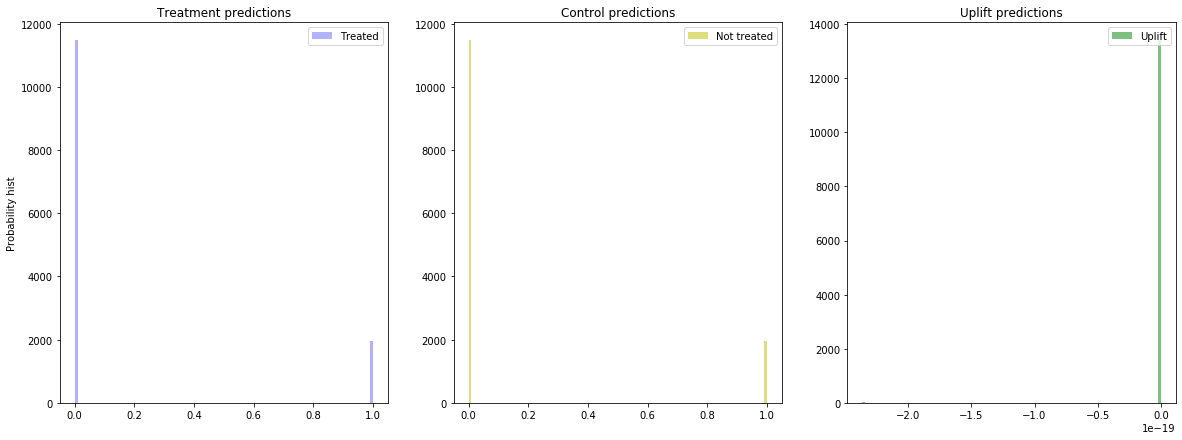

In [12]:
sm = SoloModel(LGBMClassifier(random_state=15))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_

sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Трансформация классов

In [13]:
from sklift.models import ClassTransformation


ct = ClassTransformation(LGBMClassifier(random_state=15))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

#### Две независимые модели

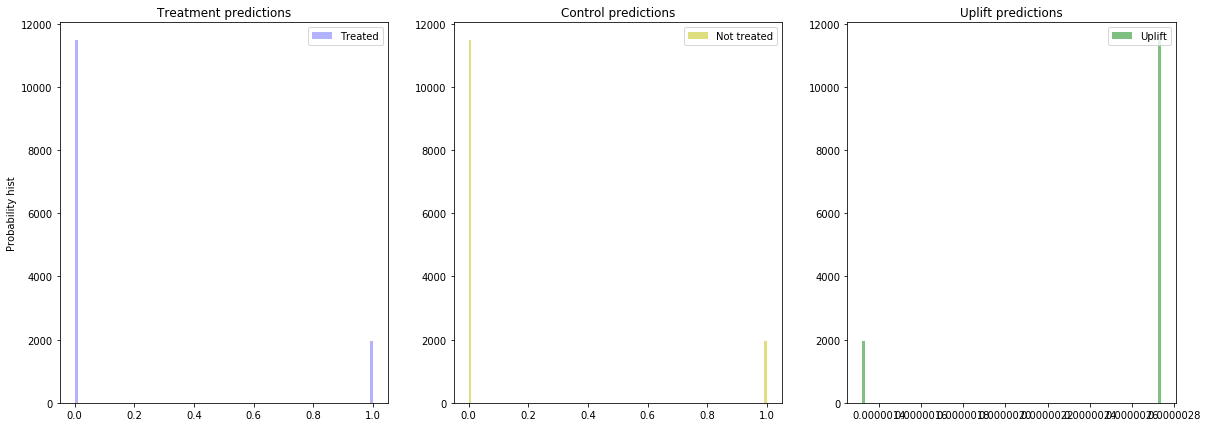

In [14]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=LGBMClassifier(random_state=15), 
    estimator_ctrl=LGBMClassifier(random_state=15), 
    method='vanilla')

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [15]:
results = pd.DataFrame(data=models_results)

results

,approach,uplift@10%,uplift@20%
0,SoloModel,0.068118,0.060354
1,ClassTransformation,1.000000,0.842223
2,TwoModels,0.000000,0.000000


Проводила сравнительное исскледование между LGBMClassifier, XGBClassifier, RandomForestClassifier, LogisticRegression. 
В 3 из 4 случаев Трансформация классов давала один результат - 1.000000	/ 0.842223. 

Только при использовании RandomForestClassifier все uplift были больше 0, в остальных случаях в таблице результатов появлялось хотя бы одно нулевое значение.

Таким образом, Трансформация классов дает не только самый высокий но и самый устойчивый результат вне зависимости от используемого алгоритма.

#### UpliftTreeClassifier

In [16]:
features = [col for col in X_train]

In [17]:
# pip install causalml

CPU times: user 25.5 s, sys: 1.7 s, total: 27.2 s
Wall time: 45.2 s


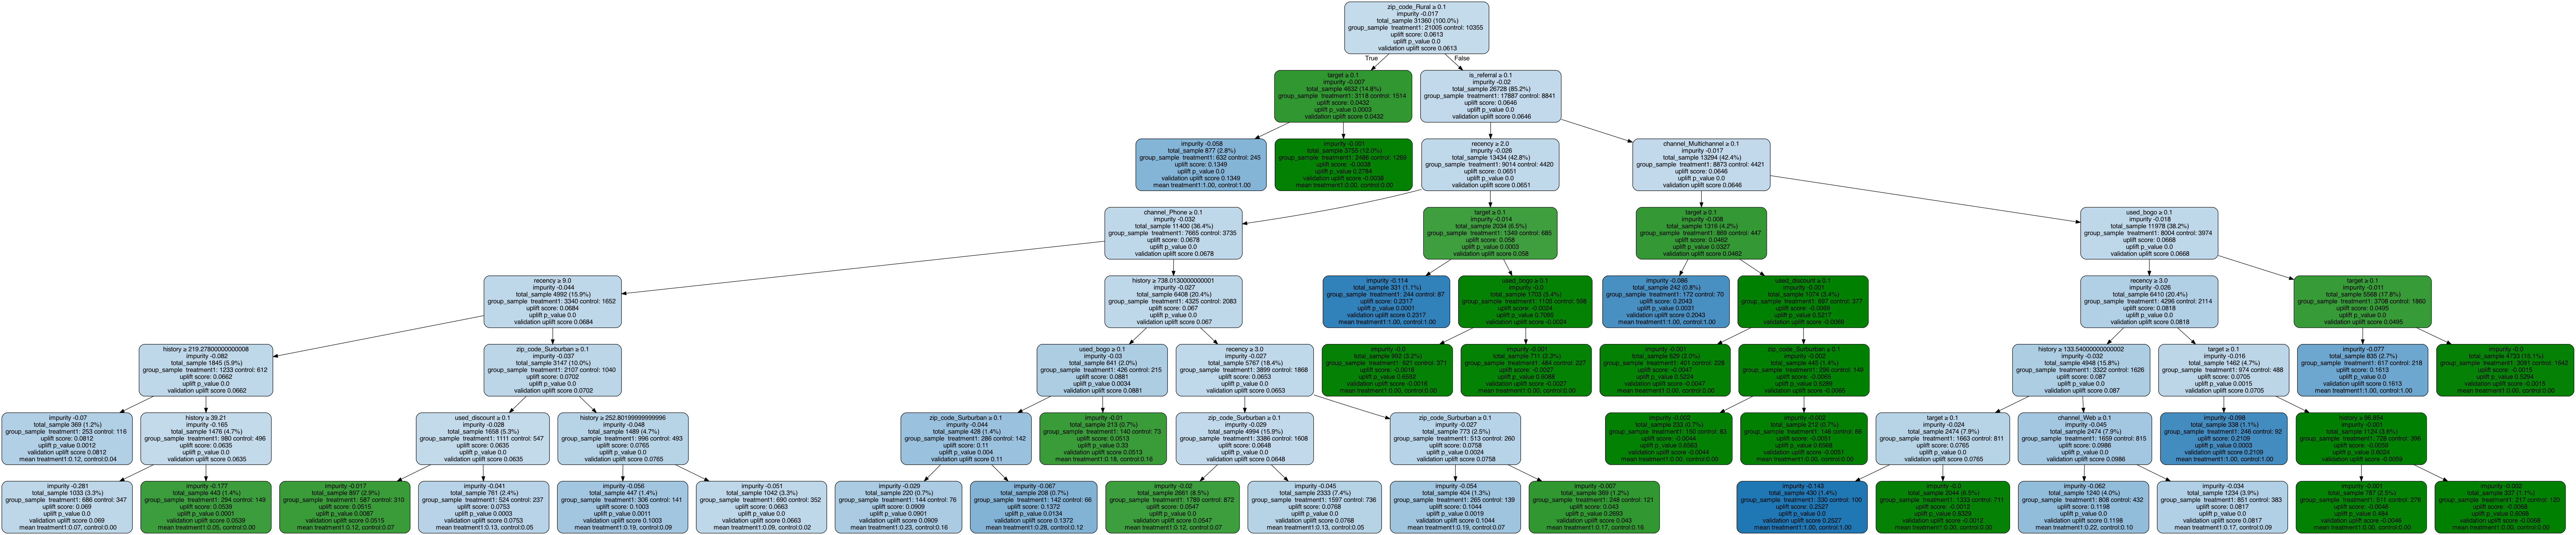

In [18]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

#### В данном дереве нет листьев,где разница mean_treatment и control существенна.